In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


fileprefix = "data/ad1_test"
df_file = f"{fileprefix}.csv"

df = pd.read_csv(df_file)
df.rename(columns={"time": "time_s"}, inplace=True)
print(df.head())

     time_s     signal
0  3.033242  13.831727
1  3.034242  13.842344
2  3.035242  13.845883
3  3.036242  13.845883
4  3.037242  13.845883
Metadata:
actinic_led_intensity: 50
measurement_led_intensity: 50
recording_length_s: 2.002
recording_hz: 1000
ared_duration_s: 2.0
wait_after_ared_s: 0.002
agreen_delay_s: 0.002
agreen_duration_s: 2.0
channel_range: 50
filename: C:\repos\FLuorInduc\data\record.csv
event_logger: [{'time_s': 0.0, 'label': 'protocol_start'}, {'time_s': 0.014367, 'label': 'test_shutter_opening'}, {'time_s': 0.014538, 'label': 'test_shutter_opened'}, {'time_s': 0.01471, 'label': 'test_shutter_closed'}, {'time_s': 0.014717, 'label': 'creating_timed_action_factory'}, {'time_s': 0.014885, 'label': 'preparing_recorder'}, {'time_s': 0.014888, 'label': 'setup_recording'}, {'time_s': 0.015707, 'label': 'recorder_prepared'}, {'time_s': 1.019948, 'label': 'data_available_at_sample_4'}, {'time_s': 1.019954, 'label': 'recorder_wait_for_data_start_complete'}, {'time_s': 1.019955, 'l

In [25]:
# rename the time column to time_s

# LOAD THE METADATA JSON FILE
import json
import re

fileprefix = "data/ad1_test"
json_file = f"{fileprefix}_metadata.json"

def pretty_print_metadata(metadata):
    print("Metadata:")
    for key, value in metadata.items():
        if key!="event_logger":
            print(f"{key}: {value}")

def pretty_print_events(event_logger_json):
    for event in event_logger_json:
        print(f"  {event['time_s']}: {event['label']}")

with open(json_file, "r") as f:
    metadata = json.load(f)
    # pretty_print_metadata(metadata)
    # pretty_print_events(metadata["event_logger"])

def get_event_logger_time_for_event(event_name_pattern, metadata):
    """
    Search for a time_s of the first event whose label matches the given pattern (case-insensitive, substring match).
    """
    pattern = re.compile(event_name_pattern, re.IGNORECASE)
    for event in metadata["event_logger"]:
        if pattern.search(event["label"]):
            return event["time_s"]
    return None

# we expect the difference between the time_s of the event "ared_on_for_2.000_seconds" and "action_ared_off_executed_at_0.000_s" to be equal to the metadata["ared_duration_s"]
ared_on_time = get_event_logger_time_for_event("ared_on", metadata)
ared_off_time = get_event_logger_time_for_event("ared_off", metadata)
ared_duration = metadata["ared_duration_s"]

# Don't use assert, but log the errors in a list and then print them out at the end
errors = []
# Green LED timing verification
agreen_on_time = get_event_logger_time_for_event("agreen_on", metadata)
agreen_off_time = get_event_logger_time_for_event("agreen_off", metadata)
agreen_duration = metadata.get("agreen_duration_s")

print(
    f"agreen_on_time: {agreen_on_time}, agreen_off_time: {agreen_off_time}, agreen_duration: {agreen_duration}"
)

if (
    agreen_on_time is not None
    and agreen_off_time is not None
    and agreen_duration is not None
):
    actual_duration = agreen_off_time - agreen_on_time
    if abs(actual_duration - agreen_duration) > 0.01:
        errors.append(
            f"Agreen LED duration mismatch: expected {agreen_duration}s, got {actual_duration:.3f}s"
        )

# ARED timing verification (moved here from above to match structure)
if ared_on_time is not None and ared_off_time is not None and ared_duration is not None:
    actual_duration = ared_off_time - ared_on_time
    if abs(actual_duration - ared_duration) > 0.01:
        errors.append(
            f"Ared LED duration mismatch: expected {ared_duration}s, got {actual_duration:.3f}s"
        )

# Sample count check
expected_duration = metadata.get("recording_length_s")
hz = metadata.get("recording_hz")
acquired_event_time = get_event_logger_time_for_event(
    "acquired_", metadata
)  # partial match

if expected_duration is not None and hz is not None:
    expected_samples = int(round(expected_duration * hz))
    print(f"Expected samples: {expected_samples}")

    # Look for the line like: "acquired_2003_samples_in_2.010_seconds"
    acquired_event = next(
        (e for e in metadata["event_logger"] if "acquired_" in e["label"]), None
    )
    if acquired_event:
        match = re.search(
            r"acquired_(\d+)_samples_in_([\d.]+)_seconds", acquired_event["label"]
        )
        if match:
            acquired_samples = int(match.group(1))
            if abs(acquired_samples - expected_samples) > 2:
                errors.append(
                    f"Sample count mismatch: expected ~{expected_samples}, got {acquired_samples}"
                )
        else:
            errors.append("Could not parse acquired samples line.")
    else:
        errors.append("No acquired_...samples... event found")

# Print summary
if errors:
    print("\n--- Validation Errors ---")
    for err in errors:
        print(" -", err)
else:
    print("\nAll metadata timing checks passed.")

agreen_on_time: 4.064146, agreen_off_time: 5.052692, agreen_duration: 2.0
Expected samples: 2002

--- Validation Errors ---
 - Agreen LED duration mismatch: expected 2.0s, got 0.989s
 - Ared LED duration mismatch: expected 2.0s, got 3.029s
 - Sample count mismatch: expected ~2002, got 1006


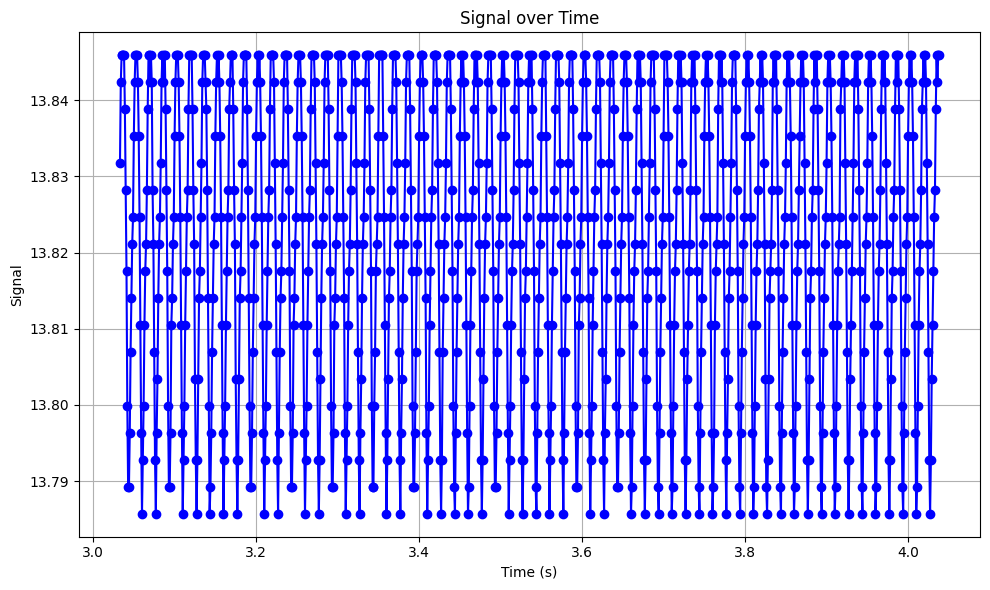

In [11]:
import numpy as np

#plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['time_s'], df['signal'], marker='o', linestyle='-', color='b')
plt.title("Signal over Time")
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.grid(True)
plt.tight_layout()
plt.show()


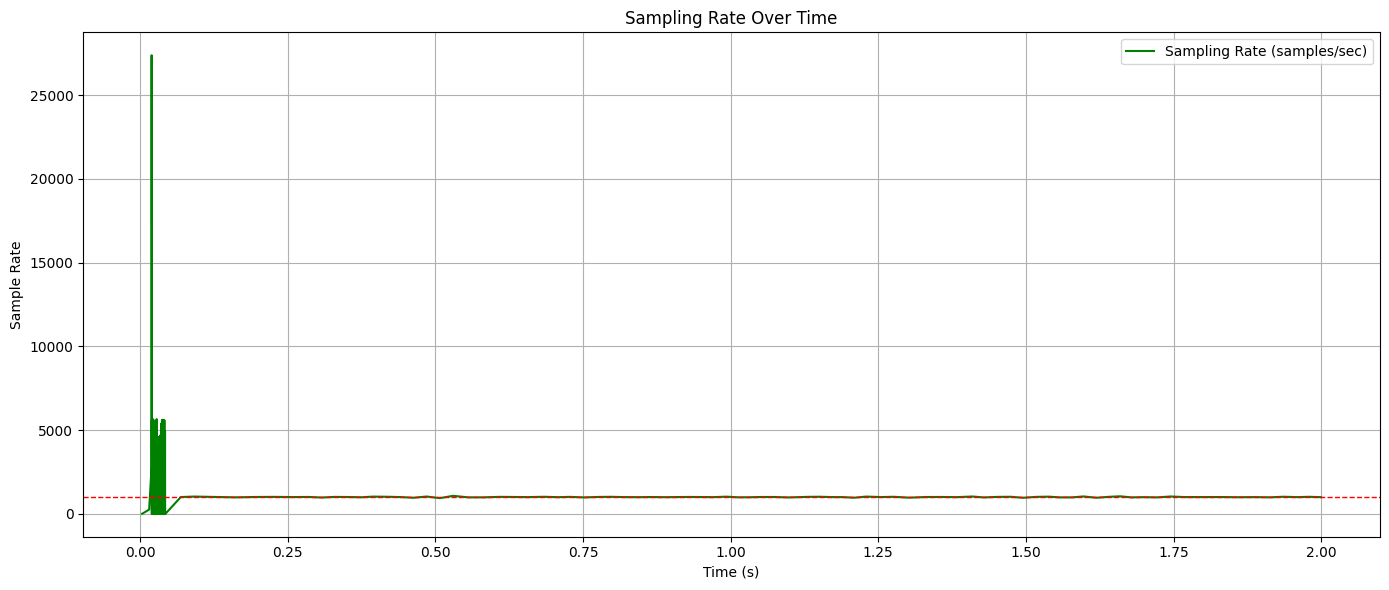

In [13]:

# Plot 2: Sampling rate over time
df["sample_rate"] = df["sample"].diff() / df["dt"]
plt.figure(figsize=(14, 6))
plt.plot(
    df["time_s"], df["sample_rate"], label="Sampling Rate (samples/sec)", color="green"
)
plt.title("Sampling Rate Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Sample Rate")
# ADD HORIZONTAL LINE AT 1000
plt.axhline(1000, color="red", linestyle="--", linewidth=1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# plot 3: mean time per sample
The mean time per sample should be very consistent across all the samples. However, we see that there is a very high variance in the time per sample. Starting from the beginning at around 0.004 s per sample, and decreasing to around 0.001 s per sample after the first 0.5s. This is showing the system coming to a steady state in terms of the time it takes to collect the samples, as well as the influence of the actions we are performing during recording. 
```python

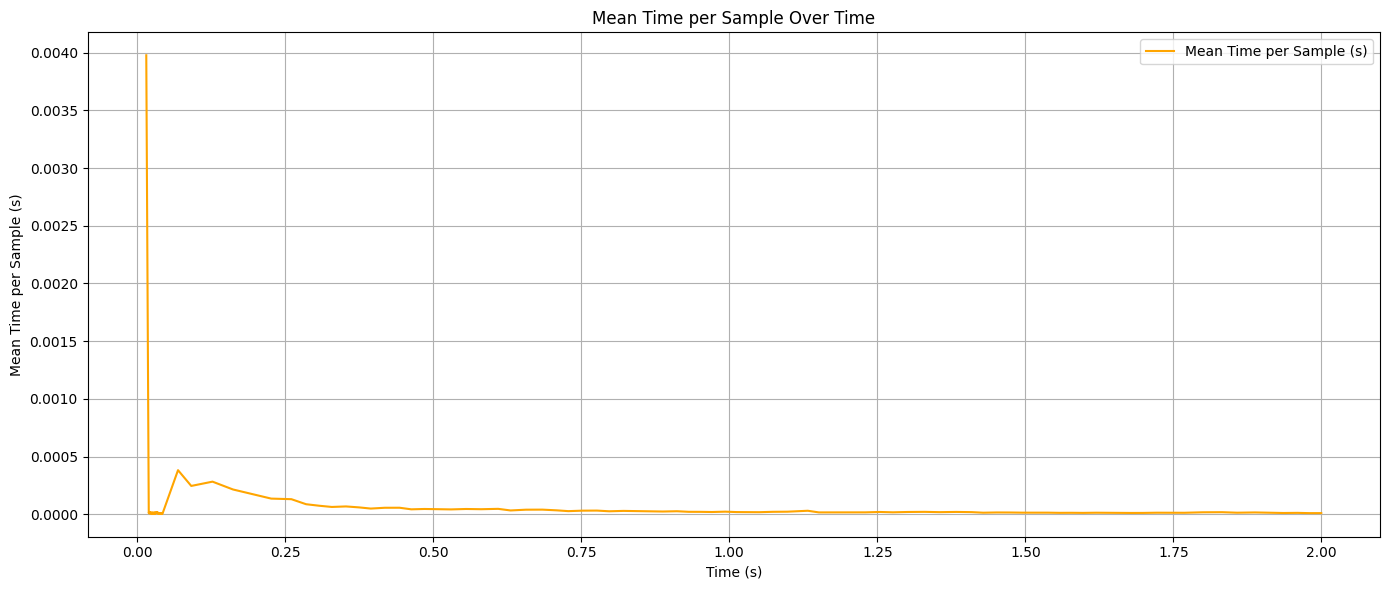

In [ ]:
# plot 3: mean time per sample


df["mean_time_per_sample"] = df["dt"] / df["sample"].replace(0, np.nan)

plt.figure(figsize=(14, 6))
plt.plot(df["time_s"], df["mean_time_per_sample"], label="Mean Time per Sample (s)", color="orange")
plt.title("Mean Time per Sample Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Mean Time per Sample (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Plot 4. Remaining samples over time

We can see a linear relation between the number of remaining samples and time. The problem is near the beginning, where there is a plateau before the samples begin to decrease. So perhaps there is a timing issue with the beginning of the recording phase, and we can start recording earlier. 

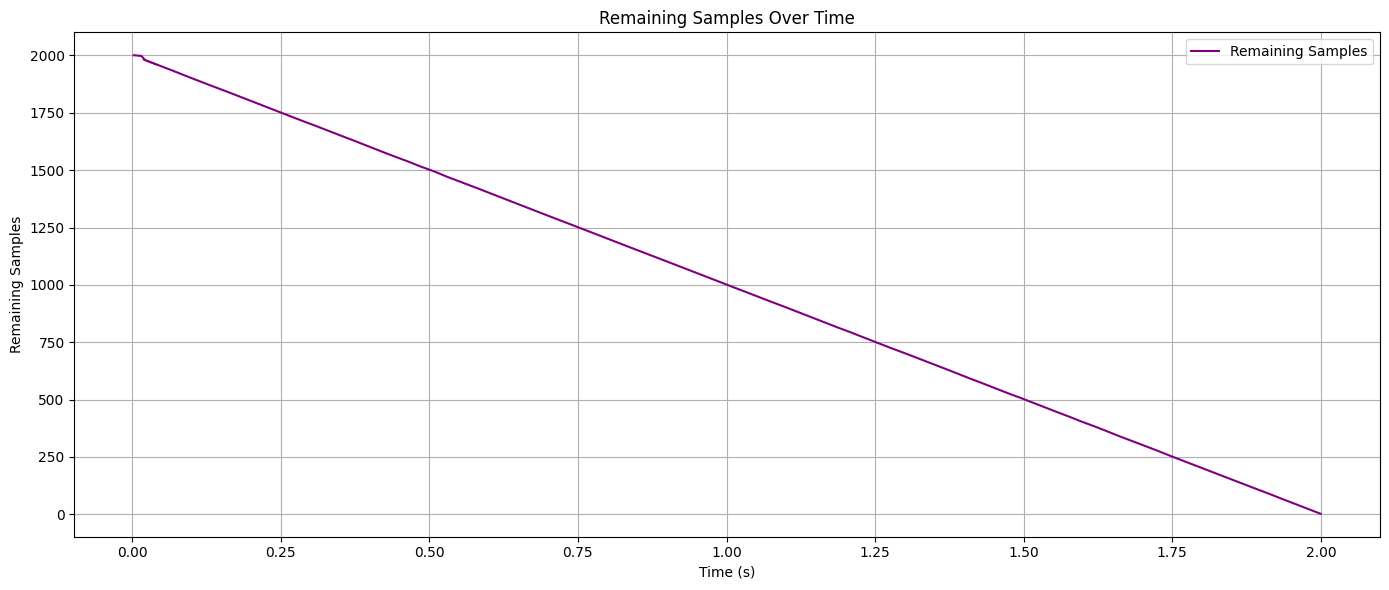

In [16]:

# plot 4: Show the remaining samples to be acquired over time
df["remaining_samples"] = df["max_samples"] - df["sample"]
plt.figure(figsize=(14, 6))
plt.plot(df["time_s"], df["remaining_samples"], label="Remaining Samples", color="purple")
plt.title("Remaining Samples Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Remaining Samples")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()